**<font size="5">Solving 1D Poisson`s problem with Finite Element Method (FEM)</font>**

V.Yaroshenko

# Table of Contents
Initialize the notebook, import all needed libs

In [1]:
from IPython.display import display, Math, Latex
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7)

Populating the interactive namespace from numpy and matplotlib


# Analytical solution

$$\frac{d^2}{dx^2}V(x) = \frac{\rho_0}{\varepsilon_0\varepsilon}$$
Boundary condition:
$$V(0) = V_0$$
$$V(d) = V_d$$

Solution:

$$V(x) = \frac{\rho_0}{2 \varepsilon_0\varepsilon}x^2-\left(\frac{\rho_0d}{2\varepsilon_0\varepsilon}+\frac{V_0}{d}\right)x+V_0$$

# FEM
Short review on qudratic elements 

Anastasis C. Polycarpou "Introduction to the Finite Element Method in Electromagnetics"
(doi:10.2200/S00019ED1V01Y200604CEM004)

Chapter 1. One-Dimensional Boundary-Value Problems

## Quadratic Elements

We can split our 1D continuous space into uniform line segments (cells), and we will address them as finite elements. Each element has coordinates $x_1$, $x_2$ and $x_3$, which correspond to local nodes 1 and 2 of the element. We can transform this coordinates to the natural ones (related to the reference cell):
$$\xi = \frac{2(x-x_3)}{x_2-x_1}$$
where
$$x_3=\frac{x_1+x_2}{2}$$

![](img/1.png)

This way the coordinate inside the cell will be $(- 1 \leq \xi \leq 1)$. We will use uniform domain discretization and approximate the solution with linear shape functions:
$$N_1(\xi)=\frac{1}{2}\xi(\xi-1)$$
$$N_2(\xi)=\frac{1}{2}\xi(\xi+1)$$
$$N_3(\xi)=(1-\xi)(1+\xi)$$

![](img/2.png)

At any point inside the master (reference) element, the primary unknown quantity of potential $V$ can be expressed as approximate value
$$
\widetilde{V}(\xi)=V_1N_1(\xi)+V_2N_2(\xi)+V_3N_3(\xi)
$$ 
or we can map it back to the real cell
$$
\widetilde{V}(x)=\left.\sum_{j=1}^{n}v_j N_j(x)\right|_{n=3}
$$
where $v_j$ are the solution values at the nodes of the element.

To calculate coefficients of matrix $K^e$ for one element:
$$K_{ij}^e = \int_{x_1}^{x_2} \left( \frac{dN_i}{dx} \right) \varepsilon 
\left(\frac{dN_j }{dx}
\right) dx$$
and vector $f^e$:
$$f_i^e=\int_{x_1}^{x_2}N_i\rho_v dx$$

$$d\xi=\frac{2}{x_2-x_1}dx=\frac{2}{l^e}dx$$
$l^e$ is the length of an element
$$dx=\frac{l^e}{2}d\xi$$

$$K_{ij}^e =\frac{2\varepsilon}{l^e} \int_{-1}^{1} \left( \frac{dN_i}{d\xi} \right) \left(\frac{dN_j }{d\xi}\right) d\xi$$
for i, j = 1, 2, 3

$$f_{i}^e =-\frac{l^e \rho}{2} \int_{-1}^{1}N_i(\xi) d\xi$$
for i = 1, 2, 3

$$K^e=\frac{\varepsilon}{3l^e}
\begin{bmatrix}
     7  &  1 & -8\\
     1  &  7 & -8\\
    -8  & -8 & 16
\end{bmatrix}$$
and 
$$f^e= -\frac{l^e \rho_0}{6}
\begin{bmatrix}
    1\\
    1\\
    4
\end{bmatrix}$$

## Assembly of Global Matrix and Vector

To understand and build global matrix K and vector f you can use the algorithm which is given in the book mentioned earlier or read next more or less simple explonation.
For this approach we need to rebuild matrix $K^e$:
$$K^e=\frac{\varepsilon}{3l^e}
\begin{bmatrix}
     K_{1,1}  &  K_{2,1} & K_{3,1}\\
     K_{1,2}  &  K_{2,2} & K_{3,2}\\
     K_{1,3}  &  K_{2,3} & K_{3,3}
\end{bmatrix} \Longrightarrow \frac{\varepsilon}{3l^e}
\begin{bmatrix}
     K_{1,1}  &  K_{3,1} & K_{2,1}\\
     K_{1,3}  &  K_{3,3} & K_{3,2}\\
     K_{1,2}  &  K_{2,3} & K_{2,2}
\end{bmatrix}$$


after rebuild:
$$K^e=\frac{\varepsilon}{3l^e}
\begin{bmatrix}
     7  &  -8 &  1\\
    -8  &  16 & -8\\
     1  &  -8 &  7
\end{bmatrix}$$
and vector $f^e$:
$$f^e= -\frac{l^e \rho_0}{6}
\begin{bmatrix}
    f_1\\
    f_2\\
    f_3
\end{bmatrix} \Longrightarrow
-\frac{l^e \rho_0}{6}
\begin{bmatrix}
    f_1\\
    f_3\\
    f_2
\end{bmatrix}$$
after rebuild:
$$f^e= -\frac{l^e \rho_0}{6}
\begin{bmatrix}
    1\\
    4\\
    1
\end{bmatrix}$$

It should be done because the third elements of matrix $K^e$ and $f^e$ describe the middle node. To build global matrix K and vector f we should connect thelast node with the first node of the next element. 

For two elements  global matrix $K$:  
$$K = \frac{\varepsilon}{3l^e}
\begin{bmatrix}
     K_{1,1}^{(1)}  &  K_{3,1}^{(1)} & K_{2,1}            &     0    &    0 \\
     K_{1,3}^{(1)}  &  K_{3,3}^{(1)} & K_{3,2}            &     0    &    0 \\
     K_{1,2}^{(1)}  &  K_{2,3}^{(1)} & K_{2,2}^{(1)} + K_{1,1}^{(2)}   &  K_{3,1}^{(2)}  & K_{2,1}^{(2)} \\
        0     &     0    & K_{1,3}^{(2)}            &  K_{3,3}^{(2)}  & K_{3,2}^{(2)} \\
        0     &     0    & K_{1,2}^{(2)}             &  K_{2,3}^{(2)}  & K_{2,2}^{(2)} 
\end{bmatrix}$$

and vector $f$:
$$f= -\frac{l^e \rho_0}{6}
\begin{bmatrix}
    f_1^{(1)} \\
    f_3^{(1)} \\
    f_2^{(1)}  + f_1^{(2)} \\
    f_3^{(2)} \\
    f_2^{(2)} 
\end{bmatrix}$$

Next step to apply boundary vondition:
$$f_i= f_i -K_{1,i}V_0$$
$$f_i= f_i -K_{N,i}V_d$$

and delete the first and the last row and column of $K$:

$$K = \frac{\varepsilon}{3l^e}
\begin{bmatrix}
      K_{3,3}^{(1)} & K_{3,2}            &     0   \\
      K_{2,3}^{(1)} & K_{2,2}^{(1)} + K_{1,1}^{(2)}   &  K_{3,1}^{(2)}  \\
     0    & K_{1,3}^{(2)}            &  K_{3,3}^{(2)}   
\end{bmatrix}$$

and the first and the last element of $f$:
 $$f= -\frac{l^e \rho_0}{6}
\begin{bmatrix}
    f_3^{(1)} \\
    f_2^{(1)}  + f_1^{(2)} \\
    f_3^{(2)}
\end{bmatrix}$$

And solve: 
$$KV=f$$

# FEM implementation

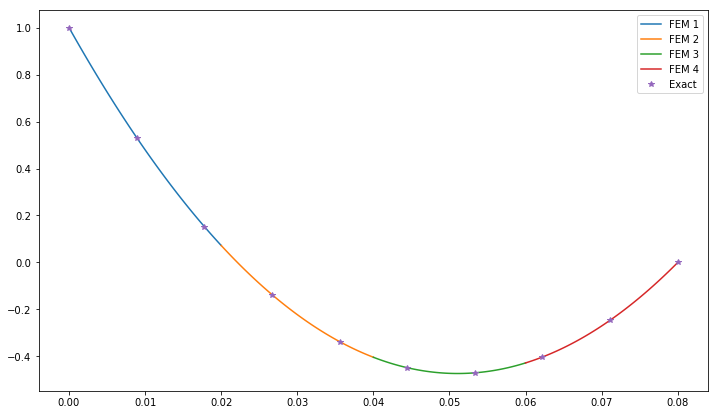

In [2]:
n = 4 #number of elements
d = 0.08 #m
le = d/n #length of element

# constants
eps_0 = 8.8541878176*10e-12 #F/m
eps_r = 1.0
eps = eps_0*eps_r
rho_0 = 10e-8 # C/m**3

#boundaries
V_0 = 1.0 #Volt
V_d = 0 #Volt
#building of matrix K
dia = np.ones(2*n+1)*(-8)
dia2 = np.zeros(2*n+1)
dia2[0:2*n+1:2] = 1
main_dia = np.ones(2*n+1)*7
main_dia[1: 2*n+1: 2] = 16
main_dia[2: 2*n: 2] += 7
K = sp.dia_matrix(([dia2, dia, main_dia, dia, dia2], [-2, -1, 0, 1, 2]), [2*n+1, 2*n+1]).toarray()

#building of vector f
f = np.ones(2*n+1)
f[1: 2*n: 2] = 4
f[2: 2*n: 2] += 1
f = -le**2*rho_0*f/eps/2

#appying of boundary condition
f = f - V_0*K[:, 0]
f = f - V_d*K[:, 2*n]
f = f[1:-1]
K = K[1:-1, 1:-1]
V = np.zeros(2*n+1)
V[0] = V_0
V[2*n] =V_d

#solving
V[1:-1] = np.linalg.solve(K, f)

#plotting
x = np.linspace(0,d, 2*n+1)
for i in range (0,2*n,2):
    x_e = np.linspace(x[i],x[i+2], 100)    
    xi = 2*(x_e-x[i+1])/(x[i+2]-x[i])
    V_e = V[i+2]*1/2*xi*(xi+1)+V[i+1]*(1-xi)*(1+xi)+V[i]*1/2*xi*(xi-1)
    plt.plot(x_e,V_e, label="FEM %i"% (int(i/2)+1) )
x1 = np.linspace(0, d,10)
exact_V = rho_0/2/eps*x1**2-(rho_0*d/2/eps+V_0/d)*x1+V_0 #exact solution
plt.plot(x1, exact_V, '*',label="Exact")
plt.legend()
plt.show()